# IMPORT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [ ]:
import tensorflow as tf

# TensorFlow에서 난수 생성 시드 고정
tf.random.set_seed(42)

# Keras에서 난수 생성 시드 고정 (케라스 사용 시 TensorFlow 백엔드를 사용하는 경우)
from keras import backend as K
K.clear_session()

In [ ]:
# data 불러오기
train = pd.read_csv('경로/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('경로/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# 데이터 전처리

#### eda

In [ ]:
import seaborn as sns

# U_WIND 컬럼의 분포 확인
plt.figure(figsize=(8, 6))
sns.histplot(train['U_WIND'], kde=True, color='skyblue')
plt.title('Distribution of U_WIND')
plt.xlabel('U_WIND')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# ARI_PO 별 U_WIND의 분포 확인
plt.figure(figsize=(12, 6))
sns.boxplot(x='ARI_PO', y='U_WIND', data=train, palette='Set2')
plt.title('U_WIND Distribution by ARI_PO')
plt.xlabel('ARI_PO')
plt.ylabel('U_WIND')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# ARI_PO 별 건수 확인
ari_po_counts = train['ARI_PO'].value_counts()

# ARI_PO 별 U_WIND가 0인 것들의 개수 확인
zero_u_wind_counts = train[train['U_WIND'] == 0]['ARI_PO'].value_counts()

print("ARI_PO 별 건수:")
print(ari_po_counts)

print("\nARI_PO 별 U_WIND가 0인 것들의 개수:")
print(zero_u_wind_counts)


In [ ]:
# ARI_PO 그룹화 후 U_WIND 값이 모두 0인 항구 확인
zero_u_wind_ports = train.groupby('ARI_PO')['U_WIND'].all()

# U_WIND 값이 모두 0인 항구만 추출
zero_u_wind_ports = zero_u_wind_ports[zero_u_wind_ports].index.tolist()

print("U_WIND 값이 모두 0인 ARI_PO:")
print(zero_u_wind_ports)


In [ ]:
# ARI_PO 그룹화 후 U_WIND 값이 모두 0인 항구 확인
zero_u_wind_ports = train.groupby('ARI_PO')['V_WIND'].all()

# U_WIND 값이 모두 0인 항구만 추출
zero_u_wind_ports = zero_u_wind_ports[zero_u_wind_ports].index.tolist()

print("U_WIND 값이 모두 0인 ARI_PO:")
print(zero_u_wind_ports)


In [ ]:
# ARI_PO 그룹화 후 U_WIND 값이 모두 0인 항구 확인
zero_u_wind_ports = train.groupby('ARI_PO')['AIR_TEMPERATURE'].all()

# U_WIND 값이 모두 0인 항구만 추출
zero_u_wind_ports = zero_u_wind_ports[zero_u_wind_ports].index.tolist()

print("U_WIND 값이 모두 0인 ARI_PO:")
print(zero_u_wind_ports)


#### 컬럼 제거

In [ ]:
# 관련성 낮은 컬럼 제거
train.drop(columns=['ID', 'SHIPMANAGER'], inplace=True)
test.drop(columns=['ID', 'SHIPMANAGER'], inplace=True)

In [ ]:
# # 결측치 많은 컬럼 제거
# columns_to_drop = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']
# train.drop(columns=columns_to_drop, inplace=True)
# test.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN' 컬럼의 결측치를 해당하는 ARI_PO의 평균값으로 채우기
columns_to_fill = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for column in columns_to_fill:
    # ARI_PO 별 해당 컬럼의 평균값 계산
    mean_values = train.groupby('ARI_PO')[column].mean()

    # 결측치를 해당 ARI_PO의 평균값으로 채우기, 결측치가 있는 경우 0으로 대체
    train[column] = train.apply(lambda row: mean_values[row['ARI_PO']] if not np.isnan(row[column]) else 0, axis=1)

# 결측치가 0으로 잘 채워졌는지 확인
print(train.isnull().sum())

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
BREADTH               1
BUILT                 0
DEADWEIGHT            0
DEPTH                 1
DRAUGHT               1
GT                    0
LENGTH                1
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
CI_HOUR               0
year                  0
month                 0
weekday               0
dtype: int64


In [ ]:
# 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN' 컬럼의 결측치를 해당하는 ARI_PO의 평균값으로 채우기
columns_to_fill = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for column in columns_to_fill:
    # train 데이터에서 ARI_PO 별 해당 컬럼의 평균값 계산
    mean_values = train.groupby('ARI_PO')[column].mean()

    # test 데이터의 결측치를 해당 ARI_PO의 평균값으로 채우기
    test[column] = test.apply(lambda row: mean_values[row['ARI_PO']] if not np.isnan(row[column]) else 0, axis=1)

# 결측치가 잘 채워졌는지 확인
print(test.isnull().sum())

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
year                  0
month                 0
weekday               0
dtype: int64


In [ ]:
# 항구명이 존재하므로 국가 없애
train.drop(['ARI_CO'], axis=1, inplace=True)
test.drop(['ARI_CO'], axis=1, inplace=True)

In [ ]:
# 그리고 배의 국가가 중요한 게 아니라 다른 원인이 있지 않을까 하고 상식선에서 일단 없애
train.drop(['FLAG'], axis=1, inplace=True)
test.drop(['FLAG'], axis=1, inplace=True)

#### 결측치 처리

In [ ]:
# # 대체할 컬럼 선택
# columns_to_impute = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# # 선택한 컬럼의 결측치를 해당 열의 평균값으로 대체
# for column in columns_to_impute:
#     train[column].fillna(train[column].mean(), inplace=True)

In [ ]:
# # 대체할 컬럼 선택
# columns_to_impute = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# # 선택한 컬럼의 결측치를 해당 열의 평균값으로 대체
# for column in columns_to_impute:
#     test[column].fillna(test[column].mean(), inplace=True)

In [ ]:
train.dropna(inplace=True)

#### 인코딩

In [ ]:
categorical_features = ['ARI_PO', 'year']

encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Train 데이터셋의 'year' 열에 대한 정수 레이블 인코딩 수행
# le = LabelEncoder()
# train['year_encoded'] = le.fit_transform(train['year'])

# # Test 데이터셋의 'year' 열에 대한 정수 레이블 인코딩 수행 (Train 데이터셋을 기반으로 transform)
# test['year_encoded'] = le.transform(test['year'])

# train.drop(columns=['year'], inplace=True)
# test.drop(columns=['year'], inplace=True)

In [ ]:
# dummy_columns = ['weekday', 'month', 'ATA_LT']
# train = pd.get_dummies(train, columns=dummy_columns, drop_first=True)
# test = pd.get_dummies(test, columns=dummy_columns, drop_first=True)

In [ ]:
train['is_weekend'] = train['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
test['is_weekend'] = test['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

# 기존의 weekday 열 삭제
train.drop(columns=['weekday'], inplace=True)
test.drop(columns=['weekday'], inplace=True)

# 결과 확인
print(train.head())  # train 데이터에서 변경된 내용 확인

   ARI_PO SHIP_TYPE_CATEGORY       DIST  BREADTH  BUILT  DEADWEIGHT  DEPTH  \
0      21          Container  30.881018     30.0     24       24300   10.0   
1      81               Bulk   0.000000     30.0     13       35900   10.0   
2      14          Container   0.000000     50.0     12      146000   30.0   
3     101          Container   0.000000     20.0     18        6910   10.0   
4      21          Container  27.037650     50.0     10      116000   20.0   

   DRAUGHT      GT  LENGTH    U_WIND    V_WIND  AIR_TEMPERATURE        BN  \
0     10.0   16700   180.0  0.000000  0.000000         0.000000  0.000000   
1     10.0   23500   180.0  0.000000  0.000000         0.000000  0.000000   
2     20.0  140000   370.0  0.000000  0.000000         0.000000  0.000000   
3     10.0    5400   120.0  0.250009 -0.006850        14.931366  1.839731   
4     10.0   96600   300.0 -0.527582 -0.075277        27.637513  2.014493   

   ATA_LT  PORT_SIZE     CI_HOUR  year  month  is_weekend  
0       

In [ ]:
# 월별 묶음에 따라 더미 변수로 인코딩
def encode_month_group(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

train['month_group'] = train['month'].apply(encode_month_group)
test['month_group'] = test['month'].apply(encode_month_group)

train.drop(columns=['month'], inplace=True)
test.drop(columns=['month'], inplace=True)

In [ ]:
# SHIP_TYPE_CATEGORY에서, 컨테이너 여부로 변경
# 'SHIP_TYPE_CATEGORY' 컬럼에서 'Container'인지 아닌지를 나타내는 더미 변수 생성
train['IsContainer'] = (train['SHIP_TYPE_CATEGORY'] == 'Container').astype(int)
test['IsContainer'] = (test['SHIP_TYPE_CATEGORY'] == 'Container').astype(int)

# 기존 'SHIP_TYPE_CATEGORY' 컬럼 삭제
train.drop(columns=['SHIP_TYPE_CATEGORY'], inplace=True)
test.drop(columns=['SHIP_TYPE_CATEGORY'], inplace=True)

In [ ]:
import pandas as pd

# ATA_LT 컬럼을 0~3, 4~7, 8~11, 12~15, 16~19, 20~23 범주로 인코딩하는 함수 정의
def encode_ATA_LT(df):
    bins = [-1, 3, 7, 11, 15, 19, 23]  # 범주를 정의합니다. 여기서 -1은 0~3 범주에 속하기 위한 임의의 값입니다.
    labels = [0, 1, 2, 3, 4, 5]  # 각 범주에 할당할 레이블을 정의합니다.
    df['ATA_LT_encoded'] = pd.cut(df['ATA_LT'], bins=bins, labels=labels, include_lowest=True)
    df['ATA_LT_encoded'] = df['ATA_LT_encoded'].astype(int)  # 정수형으로 변환

    # ATA_LT 컬럼 삭제
    df.drop(columns=['ATA_LT'], inplace=True)

    return df

# train 데이터에 적용
train = encode_ATA_LT(train)

# test 데이터에 적용
test = encode_ATA_LT(test)

# 인코딩된 결과 확인
print(train[['ATA_LT_encoded']].head())
print(test[['ATA_LT_encoded']].head())


   ATA_LT_encoded
0               1
1               3
2               1
3               3
4               3
   ATA_LT_encoded
0               4
1               1
2               2
3               0
4               2


#### 표준화 / 이상치 제거

In [ ]:
train.head()
train.shape

(391938, 20)

In [ ]:
test.shape

(220491, 19)

In [ ]:
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in ['IsContainer', 'ARI_PO','ATA_LT_encoded', 'year_encoded', 'month_group', 'is_weekend', 'CI_HOUR', 'weekday']]
numerical_columns

['DIST',
 'BREADTH',
 'BUILT',
 'DEADWEIGHT',
 'DEPTH',
 'DRAUGHT',
 'GT',
 'LENGTH',
 'U_WIND',
 'V_WIND',
 'AIR_TEMPERATURE',
 'BN',
 'PORT_SIZE',
 'year']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])

# 전처리된 데이터 확인
print(train.head())

   ARI_PO      DIST   BREADTH     BUILT  DEADWEIGHT     DEPTH   DRAUGHT  \
0      21  0.373513 -0.050197  1.313473   -0.618395 -1.071165 -0.236581   
1      81 -0.624902 -0.050197 -0.248150   -0.435763 -1.071165 -0.236581   
2      14 -0.624902  1.775111 -0.390115    1.297674  2.236850  1.937667   
3     101 -0.624902 -0.962851  0.461679   -0.892187 -1.071165 -0.236581   
4      21  0.249253  1.775111 -0.674047    0.825348  0.582843 -0.236581   

         GT    LENGTH    U_WIND    V_WIND  AIR_TEMPERATURE        BN  \
0 -0.627131 -0.331094  0.196766  0.231603        -1.046955 -1.100904   
1 -0.454123 -0.331094  0.196766  0.231603        -1.046955 -1.100904   
2  2.509915  2.173065  0.196766  0.231603        -1.046955 -1.100904   
3 -0.914630 -1.121880  0.483202  0.221278         0.382008  0.183860   
4  1.405715  1.250480 -0.407687  0.118138         1.598012  0.305904   

   PORT_SIZE     CI_HOUR      year  is_weekend  month_group  IsContainer  \
0   2.075830    3.450000 -0.448599      

In [ ]:
# 데이터프레임의 열 데이터 타입 확인
print(train.dtypes)

ARI_PO               int64
DIST               float64
BREADTH            float64
BUILT              float64
DEADWEIGHT         float64
DEPTH              float64
DRAUGHT            float64
GT                 float64
LENGTH             float64
U_WIND             float64
V_WIND             float64
AIR_TEMPERATURE    float64
BN                 float64
PORT_SIZE          float64
CI_HOUR            float64
year               float64
is_weekend           int64
month_group          int64
IsContainer          int64
ATA_LT_encoded       int64
dtype: object


In [ ]:
test[numerical_columns] = scaler.fit_transform(test[numerical_columns])

# 전처리된 데이터 확인
print(test.head())

   ARI_PO      DIST   BREADTH     BUILT  DEADWEIGHT     DEPTH   DRAUGHT  \
0      22 -0.565503  1.779669  0.460314    0.843680  2.240722  1.943187   
1      91  0.197304 -1.876448 -0.247849   -0.940568 -1.070033 -0.235927   
2      46  2.969879 -0.962419  1.593375   -0.828806 -1.070033 -0.235927   
3      20 -0.327703 -0.048390 -0.814380   -0.121034  0.585344 -0.235927   
4      67 -0.624611 -0.048390  0.601946   -0.373247  0.585344 -0.235927   

         GT    LENGTH    U_WIND    V_WIND  AIR_TEMPERATURE        BN  \
0  1.728871  1.781464 -0.465505  0.125610         1.622636  0.305598   
1 -0.987428 -1.648068  1.235607  0.026762         0.078906  0.938941   
2 -0.837373 -0.856638 -0.655836  0.176851         0.369676  0.225836   
3 -0.248893 -0.197113  0.163178  0.240549        -1.054089 -1.095124   
4 -0.210614  0.198603  0.163178  0.240549        -1.054089 -1.095124   

   PORT_SIZE  year  is_weekend  month_group  IsContainer  ATA_LT_encoded  
0   2.072815   0.0           0           

In [ ]:
# # 이상치 제거 전의 데이터 개수 확인
# original_data_size = train.shape[0]

# # train 데이터에 대한 Z-score 계산 및 이상치 제거
# z_scores_train = np.abs((train[numerical_columns] - train[numerical_columns].mean()) / train[numerical_columns].std())
# train = train[(z_scores_train < 4).all(axis=1)]

# # 이상치 제거 후의 데이터 개수 확인
# processed_data_size = train.shape[0]

# # 이상치 제거 전 후의 데이터 개수 차이 계산
# data_size_difference = original_data_size - processed_data_size

# print("이상치 제거 전 데이터 개수:", original_data_size)
# print("이상치 제거 후 데이터 개수:", processed_data_size)
# print("이상치 제거로 제거된 데이터 개수:", data_size_difference)

In [ ]:
# # 이상치 제거 전의 데이터 개수 확인
# original_data_size = train.shape[0]

# # 'CI_HOUR'의 Z-score 계산
# z_scores_ci_hour = (train['CI_HOUR'] - train['CI_HOUR'].mean()) / train['CI_HOUR'].std()

# # Z-score가 3 이상인 행 제거
# train = train[(np.abs(z_scores_ci_hour) < 4)]

# # 이상치 제거 후의 데이터 개수 확인
# processed_data_size = train.shape[0]

# # 이상치 제거 전 후의 데이터 개수 차이 계산
# data_size_difference = original_data_size - processed_data_size

# print("이상치 제거 전 데이터 개수:", original_data_size)
# print("이상치 제거 후 데이터 개수:", processed_data_size)
# print("이상치 제거로 제거된 데이터 개수:", data_size_difference)

# 모델 학습

#### 베이스라인

In [ ]:
# train 데이터프레임의 인덱스를 초기화하여 새로운 인덱스를 할당
train.reset_index(drop=True, inplace=True)

# test 데이터프레임의 인덱스를 초기화하여 새로운 인덱스를 할당
test.reset_index(drop=True, inplace=True)

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 391938, number of used features: 19
[LightGBM] [Info] Start training from score 61.940993


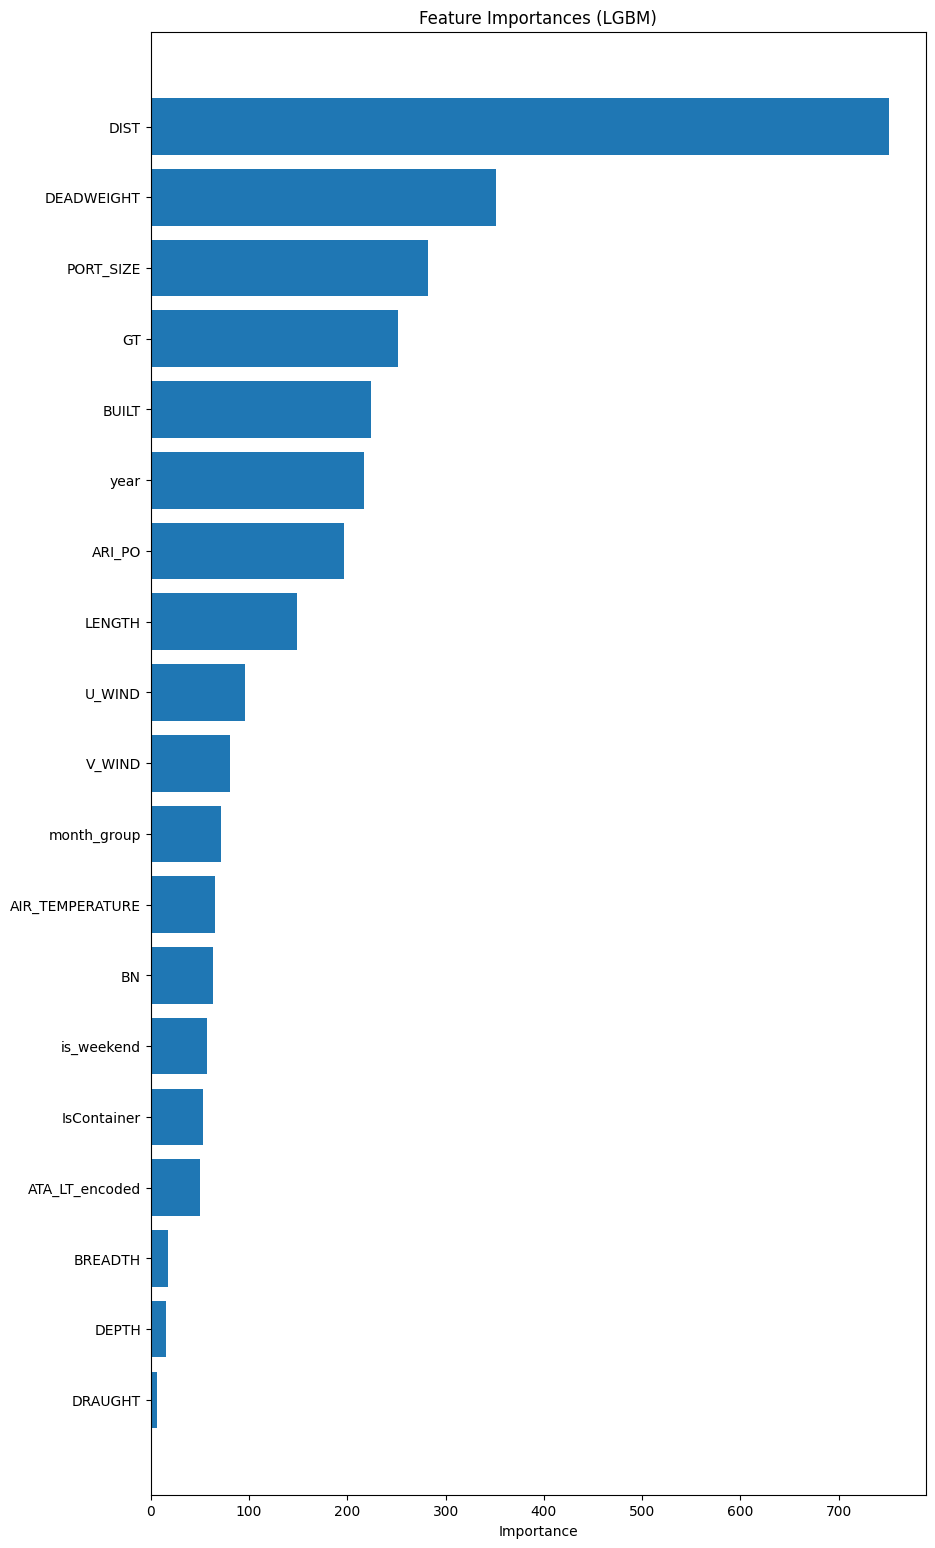

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [ ]:
threshold = 40 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.987466


Processing folds:  20%|██        | 1/5 [00:05<00:23,  5.97s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.992312


Processing folds:  40%|████      | 2/5 [00:09<00:13,  4.58s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.882006


Processing folds:  60%|██████    | 3/5 [00:13<00:08,  4.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.896651


Processing folds:  80%|████████  | 4/5 [00:18<00:04,  4.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.904242


Processing folds: 100%|██████████| 5/5 [00:21<00:00,  4.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.793767


Processing folds: 6it [00:25,  3.99s/it]                       

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 62.289782


Processing folds: 7it [00:29,  4.05s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352744, number of used features: 16
[LightGBM] [Info] Start training from score 61.734948


Processing folds: 8it [00:34,  4.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 16
[LightGBM] [Info] Start training from score 61.892118


Processing folds: 9it [00:37,  3.99s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 16
[LightGBM] [Info] Start training from score 62.036633


Processing folds: 10it [00:41,  4.13s/it]

Validation : MAE scores for each fold: [55.65239839625213, 55.52492885908156, 56.56623404234628, 56.0722932243909, 56.2141258714308, 56.636918366524, 53.4227264836139, 57.234516128553594, 55.793516685574545, 55.25293115946052]
Validation : MAE: 55.83705892172283


### 딥러닝

In [ ]:
len(train)

391938

In [ ]:
len(test)

220491

In [ ]:
# 목적 변수 추출
X = train.drop(columns=['CI_HOUR'])
y = train['CI_HOUR']

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# 딥러닝 모델 생성
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Adam 옵티마이저와 학습률 스케줄러 설정
initial_learning_rate = 0.001  # 초기 학습률
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=500000, decay_rate=0.5, staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(loss='mean_absolute_error', optimizer=optimizer)

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 데이터와 검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/100
2450/2450 [==============================] - 10s 4ms/step - loss: 51.6255 - val_loss: 49.3946
Epoch 2/100
2450/2450 [==============================] - 8s 3ms/step - loss: 49.7768 - val_loss: 49.2098
Epoch 3/100
2450/2450 [==============================] - 9s 4ms/step - loss: 49.4296 - val_loss: 48.7346
Epoch 4/100
2450/2450 [==============================] - 10s 4ms/step - loss: 49.1820 - val_loss: 48.6191
Epoch 5/100
2450/2450 [==============================] - 12s 5ms/step - loss: 48.9932 - val_loss: 48.5087
Epoch 6/100
2450/2450 [==============================] - 8s 3ms/step - loss: 48.8342 - val_loss: 48.2369
Epoch 7/100
2450/2450 [==============================] - 9s 4ms/step - loss: 48.7159 - val_loss: 48.1875
Epoch 8/100
2450/2450 [==============================] - 10s 4ms/step - loss: 48.6178 - val_loss: 48.0719
Epoch 9/100
2450/2450 [==============================] - 9s 3ms/step - loss: 48.4935 - val_loss: 48.2723
Epoch 10/100
2450/2450 [===========================

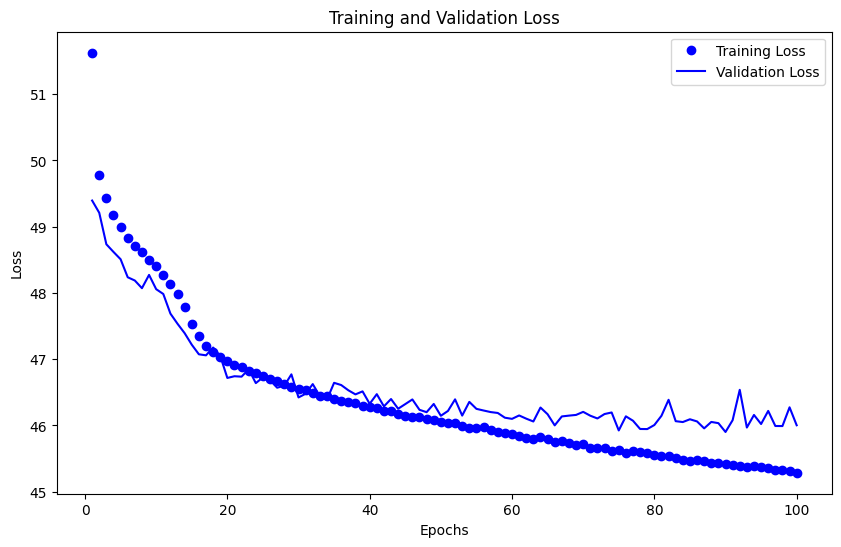

In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정에서의 로스 값
train_loss = history.history['loss']

# 검증 과정에서의 로스 값
val_loss = history.history['val_loss']

# 에폭 수
epochs = range(1, len(train_loss) + 1)

# 훈련 로스와 검증 로스 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
4900/4900 [==============================] - 29s 6ms/step - loss: 45.6011 - val_loss: 46.0904
Epoch 2/100
4900/4900 [==============================] - 18s 4ms/step - loss: 45.5259 - val_loss: 46.1591
Epoch 3/100
4900/4900 [==============================] - 17s 4ms/step - loss: 45.5486 - val_loss: 46.4606
Epoch 4/100
4900/4900 [==============================] - 18s 4ms/step - loss: 45.5495 - val_loss: 46.2894
Epoch 5/100
4900/4900 [==============================] - 18s 4ms/step - loss: 45.5088 - val_loss: 46.2100
Epoch 6/100
4900/4900 [==============================] - 18s 4ms/step - loss: 45.5313 - val_loss: 46.0597
Epoch 7/100
4900/4900 [==============================] - 17s 3ms/step - loss: 45.5187 - val_loss: 45.9996
Epoch 8/100
4900/4900 [==============================] - 17s 3ms/step - loss: 45.4887 - val_loss: 46.0792
Epoch 9/100
4900/4900 [==============================] - 18s 4ms/step - loss: 45.4590 - val_loss: 46.5453
Epoch 10/100
4900/4900 [======================

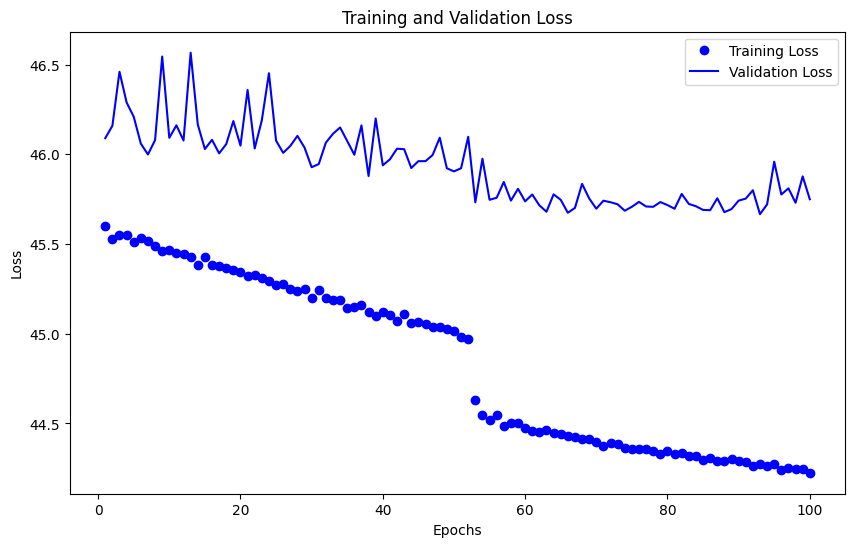

In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정에서의 로스 값
train_loss = history.history['loss']

# 검증 과정에서의 로스 값
val_loss = history.history['val_loss']

# 에폭 수
epochs = range(1, len(train_loss) + 1)

# 훈련 로스와 검증 로스 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 모델 평가
val_loss = model.evaluate(X_val, y_val)
print(f'Validation MAE: {val_loss}')

2450/2450 [==============================] - 5s 2ms/step - loss: 45.7498
Validation MAE: 45.749786376953125


In [ ]:
predictions = model.predict(test)

6891/6891 [==============================] - 11s 2ms/step


In [ ]:
print(len(predictions))

220491


In [ ]:
import numpy as np

# 예측값에 결측치 여부를 확인
has_nan = np.isnan(predictions).any()

if has_nan:
    print("Predictions contain NaN values.")
else:
    print("Predictions do not contain NaN values.")

nan_count = np.isnan(predictions).sum()

print("NaN 값의 개수:", nan_count)

Predictions do not contain NaN values.
NaN 값의 개수: 0


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Dacon/HD/sample_submission.csv')
submit['CI_HOUR'] = predictions
submit.to_csv('/content/drive/MyDrive/Dacon/HD/MLP_llast_submit.csv', index=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
# 목적 변수 추출
X = pd.DataFrame(train.drop(columns=['CI_HOUR']))
y = pd.DataFrame(train['CI_HOUR'])

In [ ]:
# 사용자 정의 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # X와 y가 데이터프레임인지 확인
        if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
            # 데이터프레임이 비어있지 않은지 확인
            if not X.empty and not y.empty:
                self.X = torch.tensor(X.values, dtype=torch.float32)  # 데이터프레임을 텐서로 변환
                self.y = torch.tensor(y.values, dtype=torch.float32)  # 데이터프레임을 텐서로 변환
            else:
                raise ValueError("데이터프레임이 비어 있습니다.")
        else:
            raise ValueError("입력된 데이터가 데이터프레임 형식이 아닙니다.")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # 입력층 -> 은닉층1
        self.relu1 = nn.ReLU()  # ReLU 활성화 함수
        self.dropout1 = nn.Dropout(dropout_prob)  # 첫 번째 드롭아웃 추가
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # 은닉층1 -> 은닉층2
        self.relu2 = nn.ReLU()  # ReLU 활성화 함수
        self.dropout2 = nn.Dropout(dropout_prob)  # 두 번째 드롭아웃 추가
        self.fc3 = nn.Linear(hidden_size2, output_size)  # 은닉층2 -> 출력층

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # 첫 번째 드롭아웃 적용
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)  # 두 번째 드롭아웃 적용
        x = self.fc3(x)
        return x

In [ ]:
# # 신경망 모델 정의
# class DNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(DNNModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)  # 입력층 -> 은닉층
#         self.relu = nn.ReLU()  # ReLU 활성화 함수
#         self.fc2 = nn.Linear(hidden_size, output_size)  # 은닉층 -> 출력층

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

In [ ]:
print(type(X_train))  # <class 'numpy.ndarray'>
print(type(y_train))  # <class 'numpy.ndarray'>

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
from tqdm import tqdm

# CUDA가 사용 가능한지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 데이터를 훈련셋과 검증셋으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터셋 및 데이터로더 생성
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 하이퍼파라미터 설정
input_size = 19
hidden_size1 = 128
hidden_size2 = 128
output_size = 1
num_epochs = 150
learning_rate = 0.001

# 모델, 손실 함수, 최적화 알고리즘 설정 및 GPU로 이동
model = DNNModel(input_size, hidden_size1, hidden_size2, output_size).to(device)
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
train_losses = []
val_losses = []

# tqdm을 이용하여 진행 상황 시각화
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # 데이터를 GPU로 옮김
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(inputs)
    average_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(average_train_loss)

    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 데이터를 GPU로 옮김
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), targets).item() * len(inputs)
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

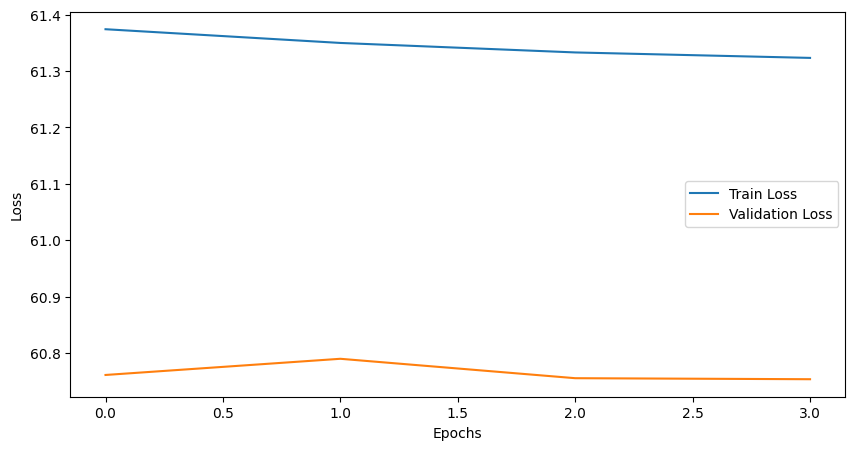

In [ ]:

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'DNN.pth')

In [ ]:
# 학습된 모델 가중치 불러오기 (만약 학습이 완료된 모델을 사용한다면 이 부분을 생략해도 됩니다.)
model.load_state_dict(torch.load('DNN.pth'))

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터를 PyTorch 텐서로 변환
test_tensor = torch.tensor(test.values, dtype=torch.float32)

# 예측 수행
with torch.no_grad():
    predictions = model(test_tensor)

# 예측 결과 출력
print(predictions)

In [ ]:
submit = pd.read_csv('경로/sample_submission.csv')
submit['CI_HOUR'] = predictions
submit.to_csv('경로/파일명.csv', index=False)